<a href="https://www.kaggle.com/code/misaelcribeiro/tps-keeping-log-of-many-models-performance?scriptVersionId=102627503" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


<h3 style="text-align: center;">Loading libraries</h3>

In [13]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import auc,roc_curve, RocCurveDisplay
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

<h4 style="text-align: center;">We are going to see which model without any hyperparameter tunning will perform best. So, let's create a dict to keep the scores updated.</h4>

In [14]:
models_performance = {}

def fit_and_draw_roc_auc(model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f'roc_auc: {roc_auc}')
    models_performance[str(model).split('(')[0]] = roc_auc
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=str(model).split('(')[0])
    display.plot()
    plt.show()
    plt.clf()

<h4 style="text-align: center;">Loading the data</h4>

In [34]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv').set_index('id')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv').set_index('id')

In [35]:
print(train_df.shape)
print(test_df.shape)

(26570, 25)
(20775, 24)


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20775 entries, 26570 to 47344
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    20775 non-null  object 
 1   loading         20552 non-null  float64
 2   attribute_0     20775 non-null  object 
 3   attribute_1     20775 non-null  object 
 4   attribute_2     20775 non-null  int64  
 5   attribute_3     20775 non-null  int64  
 6   measurement_0   20775 non-null  int64  
 7   measurement_1   20775 non-null  int64  
 8   measurement_2   20775 non-null  int64  
 9   measurement_3   20446 non-null  float64
 10  measurement_4   20366 non-null  float64
 11  measurement_5   20267 non-null  float64
 12  measurement_6   20151 non-null  float64
 13  measurement_7   20055 non-null  float64
 14  measurement_8   19929 non-null  float64
 15  measurement_9   19871 non-null  float64
 16  measurement_10  19708 non-null  float64
 17  measurement_11  19639 non-n

<h3 style="text-align: center;">Treating features...</h3>

In [37]:
attributes = [x for x in train_df.columns if x.startswith('attribute')]
measurements = [x for x in train_df.columns if x.startswith('measurement')]
attributes, measurements

(['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3'],
 ['measurement_0',
  'measurement_1',
  'measurement_2',
  'measurement_3',
  'measurement_4',
  'measurement_5',
  'measurement_6',
  'measurement_7',
  'measurement_8',
  'measurement_9',
  'measurement_10',
  'measurement_11',
  'measurement_12',
  'measurement_13',
  'measurement_14',
  'measurement_15',
  'measurement_16',
  'measurement_17'])

In [52]:
null_cols = train_df.isnull().sum().sort_values(ascending=False)
null_cols = list(null_cols[null_cols>1].index)
null_cols

[]

In [9]:
object_cols = list(train_df.select_dtypes(include=['object']))
numerics_cols = list(train_df.select_dtypes(exclude=['object']))
numerics_cols.remove('failure')
numerics_cols

['loading',
 'attribute_2',
 'attribute_3',
 'measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

sp = SimpleImputer(strategy='mean')

ct = ColumnTransformer([("imp", SimpleImputer(), null_cols)])
    
train_df[null_cols] = ct.fit_transform(train_df[null_cols])
test_df[null_cols] = ct.fit_transform(test_df[null_cols])

In [53]:
#One Hot Encoding

full_df_for_dummies = pd.concat([train_df, test_df])
full_df_for_dummies = pd.get_dummies(full_df_for_dummies)
train_df = full_df_for_dummies.iloc[0:26570,:]
test_df = full_df_for_dummies.iloc[26570:,:]
test_df.drop('failure', inplace=True, axis=1)

del full_df_for_dummies

#train_df.fillna(0, inplace=True)
#test_df.fillna(0, inplace=True)

X = train_df.copy()
y = X.pop('failure')
#test_df.drop('failure', axis=1, inplace=True)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler

#ct = ColumnTransformer(
#    [("standS", StandardScaler(), numerics_cols)])
     
#X_train[numerics_cols] = ct.fit_transform(X_train[numerics_cols])
#X_test[numerics_cols] = ct.fit_transform(X_test[numerics_cols])
#test_df[numerics_cols] = ct.fit_transform(test_df[numerics_cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


roc_auc: 0.5910621079812663


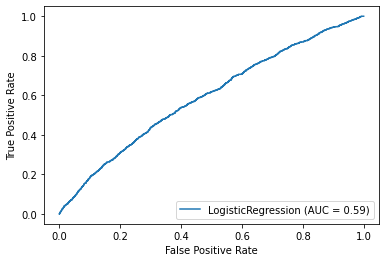

<Figure size 432x288 with 0 Axes>

In [54]:
fit_and_draw_roc_auc(LogisticRegression(penalty="l2", solver='liblinear'))

roc_auc: 0.5625731615179334


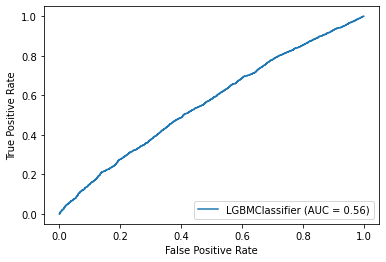

<Figure size 432x288 with 0 Axes>

In [55]:
fit_and_draw_roc_auc(LGBMClassifier())

roc_auc: 0.5323550902041659


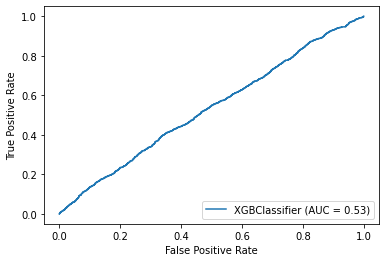

<Figure size 432x288 with 0 Axes>

In [56]:
fit_and_draw_roc_auc(XGBClassifier())

roc_auc: 0.5481512226282698


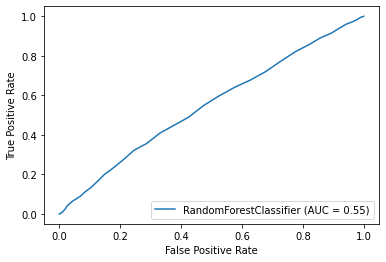

<Figure size 432x288 with 0 Axes>

In [57]:
fit_and_draw_roc_auc(RandomForestClassifier())

roc_auc: 0.5834964098839253


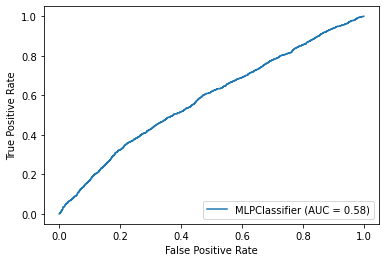

<Figure size 432x288 with 0 Axes>

In [58]:
fit_and_draw_roc_auc(MLPClassifier(max_iter=400))

roc_auc: 0.5113836754833389


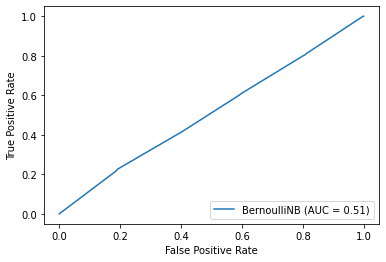

<Figure size 432x288 with 0 Axes>

In [59]:
fit_and_draw_roc_auc(BernoulliNB())

roc_auc: 0.5637041588708779


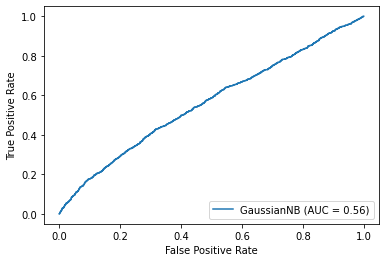

<Figure size 432x288 with 0 Axes>

In [60]:
fit_and_draw_roc_auc(GaussianNB())

<h3 style="text-align: center;">Let's see the two models that performed better and perform a Grid Search on it!</h3>

In [61]:
models_performance

{'LogisticRegression': 0.5910621079812663,
 'LGBMClassifier': 0.5625731615179334,
 'XGBClassifier': 0.5323550902041659,
 'RandomForestClassifier': 0.5481512226282698,
 'MLPClassifier': 0.5834964098839253,
 'BernoulliNB': 0.5113836754833389,
 'GaussianNB': 0.5637041588708779}

<h3 style="text-align: center;">Logistic Regression rocks! Grid Search time:</h3>

In [91]:
param_grid = {'penalty':('l1', 'l2'), 'C':[0.5, 1, 2, 5, 10]}
LR = LogisticRegression(solver='liblinear')
clf = GridSearchCV(LR, param_grid, scoring='roc_auc', n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', return_train_score=False)
clf.fit(X, y)
print(clf.best_params_)

{'C': 10, 'penalty': 'l1'}


In [93]:
final_lr = LogisticRegression(penalty="l1", solver='liblinear', C=10)
final_lr.fit(X, y)
final_predictions = final_lr.predict_proba(test_df)

In [29]:
submission = pd.DataFrame(index=test_df.index)
submission['failure'] =  final_predictions[:, 1]
submission.to_csv('submission.csv')